In [185]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from typing import Callable, Tuple

Метод золотого сечения

In [186]:
def golden_ratio_method(
    f: Callable[[float], float], a: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    K = (np.sqrt(5) - 1) / 2
    x = b - (b - a) * K
    y = a + (b - a) * K
    
    fx, fy= f(x), f(y)
    
    for k in range(max_iter):
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * K
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * K
            fy = f(y)
        
        if (b - a) * K < epsilon:
            break
    
    return (x, fx) if fx < fy else (y, fy)

Метод парабол

In [187]:
# Явная формула
def parabola_method(
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)
    if not (fa > fc < fb):
        raise ValueError("Must be f(a) > f(c) < f(b)")

    for k in range(max_iter):
        try:
            u = c - ( (c - a)**2 * (f(c) - f(b)) - (c - b)**2 * (f(c) - f(a)) ) /  \
                ( 2 * ((c - a) * (f(c) - f(b)) - (c - b) * (f(c) - f(a))) )
            fu = f(u)
        except ZeroDivisionError:
            u = (a + b) / 2

        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu
        
        if abs(b - a) < epsilon:
            break
    
    if fa <= fc and fa <= fb:
        return a, fa
    elif fc <= fa and fc <= fb:
        return c, fc
    else:
        return b, fb

# numpy.linalge.solve
def parabola_method_numpy   (
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)
    if not (fa > fc < fb):
        raise ValueError("Must be f(a) > f(c) < f(b)")
    
    for k in range(max_iter):
        A = np.array([
            [a**2, a, 1],
            [c**2, c, 1],
            [b**2, b, 1]
        ])
        B = np.array([fa, fc, fb])
        a_coeff, b_coeff, _ = np.linalg.solve(A, B)
        u = -b_coeff / (2 * a_coeff)
        fu = f(u)

        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu
        
        if abs(b - a) < epsilon:
            break
    
    if fa <= fc and fa <= fb:
        return a, fa
    elif fc <= fa and fc <= fb:
        return c, fc
    else:
        return b, fb

Метод Брента

In [188]:
def brent_method(
    f: Callable[[float], float], a: float, c: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    K = (3 - np.sqrt(5)) / 2
    x = w = v = (a + c) / 2
    fx = fw = fv = f(x)
    d = e = c - a

    for k in range(max_iter):
        u = None
        g = e
        e = d

        if len({x, w, v}) == 3 and len({fx, fw, fv}) == 3:
            try:
                u = x - ((x - v)**2 * (fx - fw) - (x - w)**2 * (fx - fv)) / \
                    (2 * ((x - v) * (fx - fw) - (x - w) * (fx - fv)))
            except ZeroDivisionError:
                u = None

        if u is not None and a + epsilon <= u <= c - epsilon and abs(u - x) < g / 2:
            d = abs(u - x)
        else:
            if x < (c + a) / 2:
                u = x + K * (c - x)
                d = c - x
            else:
                u = x - K * (x - a)
                d = x - a

        if abs(u - x) < epsilon:
            u = x + np.sign(u - x) * epsilon
            
        fu = f(u)

        if fu <= fx:
            if u >= x:
                a = x
            else:
                c = x
            v, w, x = w, x, u
            fv, fw, fx = fw, fx, fu
        else:
            if u >= x:
                c = u
            else:
                a = u
            if fu <= fw or w == x:
                v, w, fv, fw = w, u, fw,fu
            elif fu <= fv or v == x or v == w:
                v, fv = u, fu

        if abs(c - a) < 2 * epsilon or abs(fx - fw) < epsilon:
            break

    return x, fx

Исследуемые функции

In [189]:
def f1(x: float):
    return -5*x**5 + 4*x**4 - 12*x**3 + 11*x**2 - 2*x + 1

def f2(x: float):
    return -(np.log(x-2))**2 + (np.log(10-x))**2 - x**0.2

def f3(x: float):
    return -3*x * np.sin(0.75*x) + np.exp(-2*x)

def f4(x: float):
    return np.exp(3*x) + 5*np.exp(-2*x)

def f5(x: float):
    return 0.2*x * np.log(x) + (x-2.3)**2

Получение эталонных значений $x$

In [190]:
def get_reference_min(f, a, b, c=None):
    epsilon = 1e-12
    max_iter = 10000
    candidates = []

    candidates.append(golden_ratio_method(f, a, b, epsilon, max_iter))
    
    if c is None:
        c = (a + b) / 2

    if f(a) > f(c) < f(b):
        candidates.append(parabola_method(f, a, c, b, epsilon, max_iter))
        candidates.append(parabola_method_numpy(f, a, c, b, epsilon, max_iter))
        candidates.append(brent_method(f, a, b, epsilon, max_iter))
    
    return min(candidates, key=lambda t: t[1])

Применим оптимизацию

In [191]:
functions = [f1, f2, f3, f4, f5]
intervals = [
    [-0.5, 0.5],
    [6, 9.9],
    [0, 2*np.pi],
    [0, 1],
    [0.5, 2.5]
]
results_all = []
errors_all = []
x_space = range(1, 121, 1)

for i, f in enumerate(functions):
    a, b = intervals[i]
    c = (a + b) / 2
    ref_x, ref_fx = get_reference_min(f, a, b, c)

    method_results = [
        [golden_ratio_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space],
        [parabola_method(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space] if (f(a) > f(c) < f(b)) else None,
        [parabola_method_numpy(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space] if (f(a) > f(c) < f(b)) else None,
        [brent_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space] if (f(a) > f(c) < f(b)) else None
    ]

    reference_points = [
        golden_ratio_method(f, a, b, max_iter=10000, epsilon=1e-12)[0],
        parabola_method(f, a, c, b, max_iter=10000, epsilon=1e-12)[0] if (f(a) > f(c) < f(b)) else None,
        parabola_method_numpy(f, a, c, b, max_iter=10000, epsilon=1e-12)[0] if (f(a) > f(c) < f(b)) else None,
        brent_method(f, a, b, max_iter=10000, epsilon=1e-12)[0] if (f(a) > f(c) < f(b)) else None
    ]
    method_errors = [
        [abs(x_k - ref_x) for x_k in method_results[j]] if method_results[j] else None
        for j in range(4)
    ]

    results_all.append(method_results)
    errors_all.append(method_errors)
    

Нарисуем графики

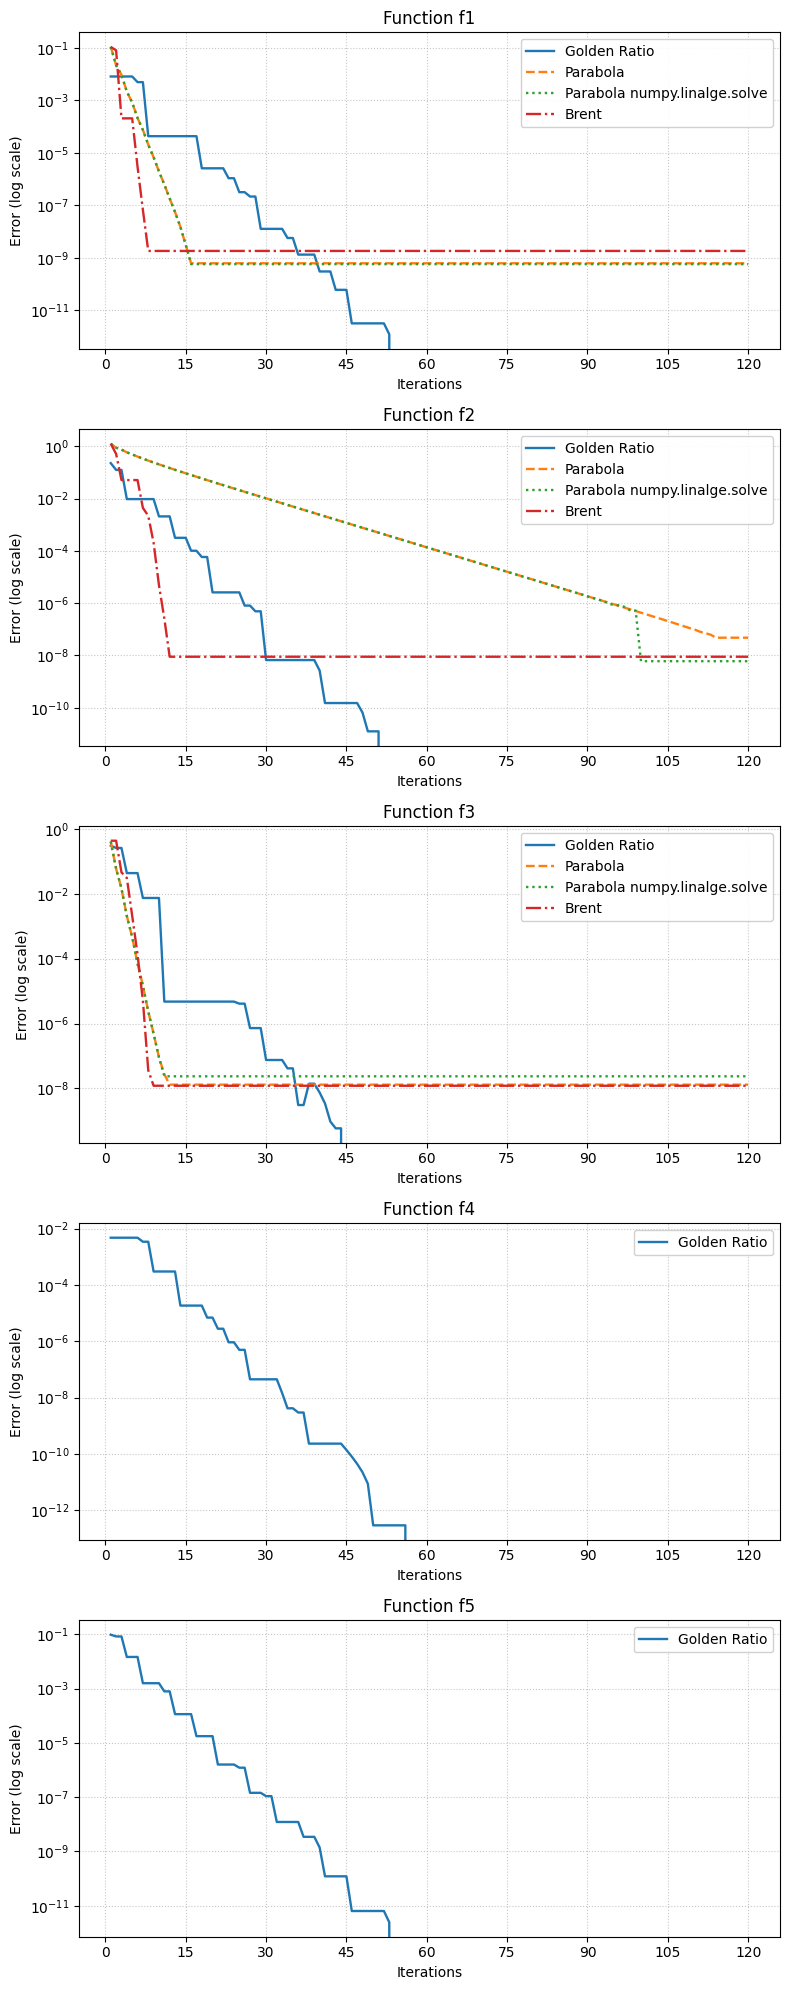

In [192]:
method_names = ["Golden Ratio", "Parabola", "Parabola numpy.linalge.solve", "Brent"]

fig, axes = plt.subplots(5, 1, figsize=(8, 20))
fig.subplots_adjust(hspace=0.5)

line_styles = ['-', '--', ':', '-.']

for i in range(5):
    ax = axes[i]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    
    for method_idx in range(4):
        method_name = method_names[method_idx]
        if errors_all[i][method_idx] is not None:
            ax.plot(x_space, errors_all[i][method_idx], 
                   linestyle=line_styles[method_idx],
                   label=method_name,
                   linewidth=1.7)
    
    ax.legend(fontsize=10, framealpha=0.9)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()